## Baseline 모델링

In [1]:
import numpy as np
import os
import PIL # 파이썬 이미지 처리용 라이브러리이다.
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import pathlib
dataset_dir = './torch_project/dataset/'
data_dir = pathlib.Path(dataset_dir)

pathlib.Path 객체를 통해 주소를 객체처럼 다룰 수 있다.

In [3]:
data_dir

PosixPath('torch_project/dataset')

In [4]:
image_count = list(data_dir.glob('*/*'))
class_count = list(data_dir.glob('*'))

print('data count:', len(image_count),'/','class count:', len(class_count))

data count: 40000 / class count: 34


총 학습데이터의 경우 40000장  
클래스의 경우 33개의 클래스가 있다.  
이때 Mac의 경우 DS_Store 폴더 제거를 해주어야 한다.

glob 메서드 이용시 형식을 만족하는 파일을 개수로 받기 가능

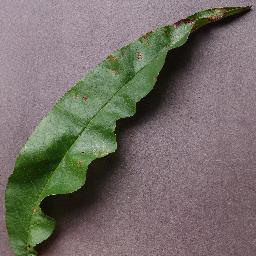

In [5]:
peaches = list(data_dir.glob('Peach___Bacterial_spot/*'))
PIL.Image.open(str(peaches[0]))

'Peach__Bacterial_spot'의 데이터 하나를 확인하였다.

## 데이터 세트 구성하기

tensorflow의 경우 image dataloader에 대해 어느정도 메서드들이 구현되어 있다.  
이러한 것들을 이용하여 데이터에 대한 Pipeline을 손쉽게 구성가능하다.

In [6]:
batch_size = 256
img_height = 64
img_width = 64
# batch_size, height, width를 설정

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training", # 학습세트
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40000 files belonging to 33 classes.
Using 32000 files for training.
Metal device set to: Apple M1 Pro


2022-07-27 17:46:41.905104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-27 17:46:41.905238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation", # 검증세트
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40000 files belonging to 33 classes.
Using 8000 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


tf.keras.preprocessing.image_dataset_from_directory()를 이용하여 데이터 객체를 정의할 경우 다음과 같이 class_names을 통해 클래스를 처리 가능하다.  
정말 편하다.

2022-07-27 17:46:43.683642: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


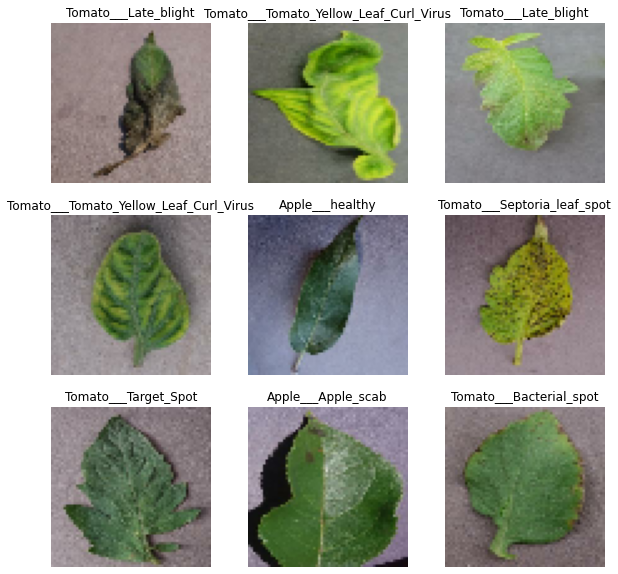

In [10]:
# 훈련 데이터셋의 처음 9개 이미지 추출
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(256, 64, 64, 3)
(256,)


image_batch의 경우 32x180x180x3 형태의 4차원 텐서이고  
label은 총 32개 존재

In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

데이터에 대해 MinMaxScaling 진행  
이미지의 경우 화소가 255가 최대이므로 1./255로 진행.  
MinMaxScaling은 수학적으로 정보의 압축을 의미한다.  
또한 스케일링을 진행하며 값이 같은 경향성을 띄어도 다르게 나오는 것을 어느정도 방지해준다.

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.7686275


최대값이 0.768275로 변경되었다.  
원래 pixel의 최대값은 195.91 이다.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = 33

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(rate=0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(num_classes, activation=tf.nn.log_softmax)
])

In [16]:
model.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

마지막 layer에서 softmax 함수를 적용시켰는데, 소프트맥스 함수를 적용시키면 값이 하나로 결정되서 나오므로 SparseCategoricalCrossentropy(from_logits = True)를 적용시켜야 한다.

In [17]:
input_shape = (None, 64, 64, 3)

모델의 요약본을 보기 위해선 .build메서드를 사용하여야 하고, 이를 위해선 input_shape를 정의해주어야 한다.  
데이터셋의 경우 64x64의 rgb이미지이고, batch_size를 256으로 적용시켜 4차원 텐서 형태이다.

In [18]:
model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                    

$O=(I+2P-F)/S + 1$  
O : Feature Map 사이즈  
I : Input 사이즈  
P : Padding의 크기  
F : Filter의 크기  
S : Stride의 크기  
Padding을 해줌으로서 Convolution을 적용하여도 이미지의 크기는 변하지 않는다.  
Convolution 연산을 전부 진행후 Flatten()을 해주어 8x8x64=4096 해주어
Dense layer에 연결 해주었다.

In [20]:
filepath = './baseline'
callbacks = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    monitor='val_loss'
)

val_ds의 loss 값을 기준으로 가장 작은 값일때 가중치를 저장한다.

In [21]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  callbacks=[callbacks]
)

Epoch 1/30


2022-07-27 17:46:44.984388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 2.5879 - accuracy: 0.2971

2022-07-27 17:46:54.010264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 11s 84ms/step - loss: 2.5879 - accuracy: 0.2971 - val_loss: 1.3312 - val_accuracy: 0.6336
Epoch 2/30
125/125 [==============================] - 9s 71ms/step - loss: 0.9813 - accuracy: 0.6939 - val_loss: 0.8126 - val_accuracy: 0.7414
Epoch 3/30
125/125 [==============================] - 9s 69ms/step - loss: 0.4973 - accuracy: 0.8388 - val_loss: 0.7944 - val_accuracy: 0.7533
Epoch 4/30
125/125 [==============================] - 9s 69ms/step - loss: 0.2955 - accuracy: 0.9018 - val_loss: 0.6755 - val_accuracy: 0.7910
Epoch 5/30
125/125 [==============================] - 9s 68ms/step - loss: 0.2091 - accuracy: 0.9278 - val_loss: 0.6553 - val_accuracy: 0.8036
Epoch 6/30
125/125 [==============================] - 9s 68ms/step - loss: 0.1328 - accuracy: 0.9570 - val_loss: 0.6016 - val_accuracy: 0.8325
Epoch 7/30
125/125 [==============================] - 9s 69ms/step - loss: 0.0918 - accuracy: 0.9717 - val_loss: 0.5979 - val_accuracy: 0.8426
Epoch 8/3

## Fine Tuning

In [22]:
resnet = tf.keras.applications.ResNet50(include_top=False ,weights='imagenet',
                                       input_shape=(64, 64, 3))

In [23]:
for layer in resnet.layers[0:6]:
    layer.trainable = False

상단의 0~5번 layer는 기존의 가중치를 유지하도록 동결해줌.

In [24]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

마지막 레이어의 경우 2x2x2048 의 형태이므로 이를 Flatten() layer를 추가하여 Dense layer에 추가해주어야 한다.

In [25]:
resnet_model = tf.keras.Sequential([
    tf.keras.layers.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229, 0.224, 0.225]),
    resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.log_softmax)
])

resnet의 가중치의 mean, variance를 이용하여 standardization을 적용시켜주었다.

In [26]:
def scheduler(epoch, lr):
    if epoch % 3 == 0:
        return lr*0.1
    else:
        return lr

resnet의 경우 어느정도 학습이 잘 되어있어 learning_rate scheduler를 활용하였다.

In [27]:
resnet_model.build(input_shape=input_shape)

In [28]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 64, 64, 3)        0         
 n)                                                              
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 33)                270369    
                                                                 
Total params: 23,858,081
Trainable params: 23,795,361
Non-trainable params: 62,720
_________________________________________________________________


In [29]:
callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [30]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [31]:
resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[callbacks]
)

Epoch 1/5


2022-07-27 17:51:08.113729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 0.7872 - accuracy: 0.7866

2022-07-27 17:51:53.571467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 52s 386ms/step - loss: 0.7872 - accuracy: 0.7866 - val_loss: 0.5298 - val_accuracy: 0.8316 - lr: 1.0000e-04
Epoch 2/5
125/125 [==============================] - 48s 381ms/step - loss: 0.0500 - accuracy: 0.9856 - val_loss: 0.1826 - val_accuracy: 0.9406 - lr: 1.0000e-04
Epoch 3/5
125/125 [==============================] - 48s 381ms/step - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.1703 - val_accuracy: 0.9460 - lr: 1.0000e-04
Epoch 4/5
125/125 [==============================] - 47s 380ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.1609 - val_accuracy: 0.9495 - lr: 1.0000e-05
Epoch 5/5
125/125 [==============================] - 47s 378ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1615 - val_accuracy: 0.9499 - lr: 1.0000e-05


epoch 수가 낮아도 기존의 가중치를 통해 엄청 우수한 모델을 만들 수 있다.